<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
C:\Users\SHIVASHANKAR\AppData\Local\Temp\ipykernel_7100\2726560618.py:21: SyntaxWarning: invalid escape sequence '\P'
  file_path = "E:\Projects\data3_Cardiofocus_revenue.csv"


Initial data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2018-07-31 to 2025-07-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes
None
            Revenue
Date               
2018-07-31     7.64
2018-10-31     7.45
2019-01-31     7.52
2019-04-30     7.95
2019-07-31     7.71

Time series after setting freq & interpolation:
Length: 84 | Non-missing: 0
Date
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
2018-12-01   NaN
Freq: MS, Name: Revenue, dtype: float64


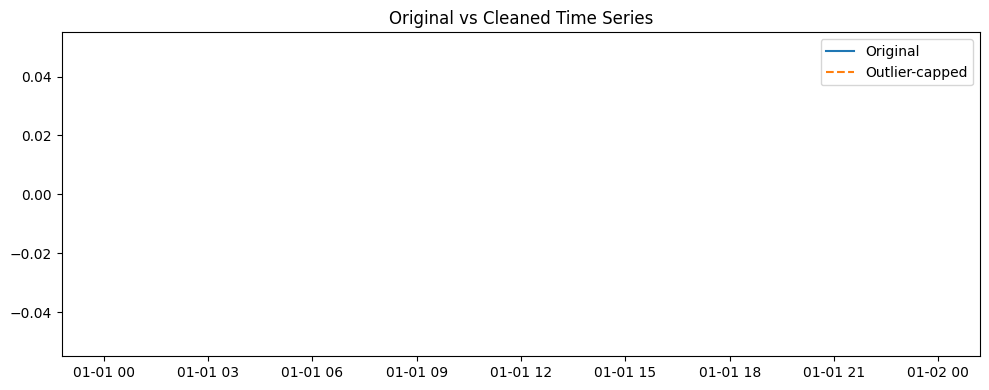

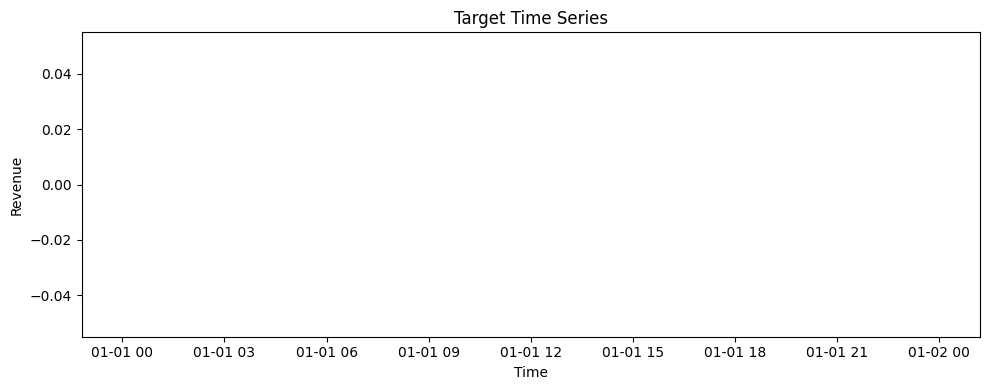


Augmented Dickey-Fuller Test: Original Series
Length after dropna: 0
❗ Not enough data points for ADF test (need at least ~10). Skipping.
❗ Not enough data for ACF/PACF of original series.

Augmented Dickey-Fuller Test: 1st Difference
Length after dropna: 0
❗ Not enough data points for ADF test (need at least ~10). Skipping.
❗ Not enough data for ACF/PACF of differenced series.

Train size: 72
Test size : 12

==== ARIMA ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


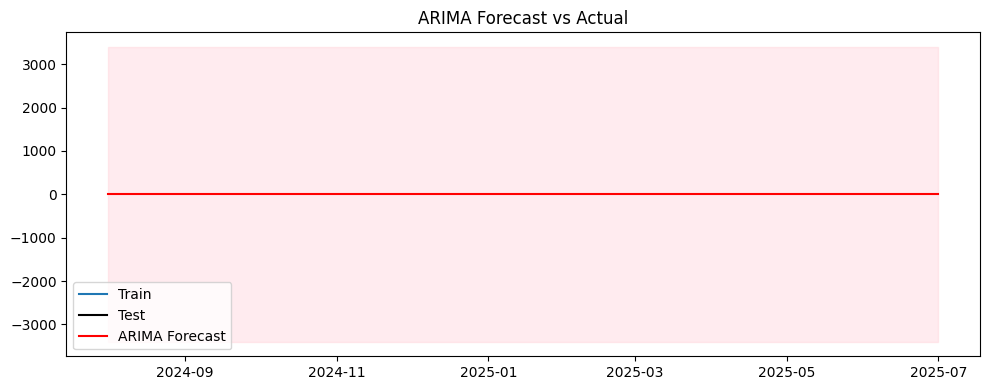


==== SARIMA ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


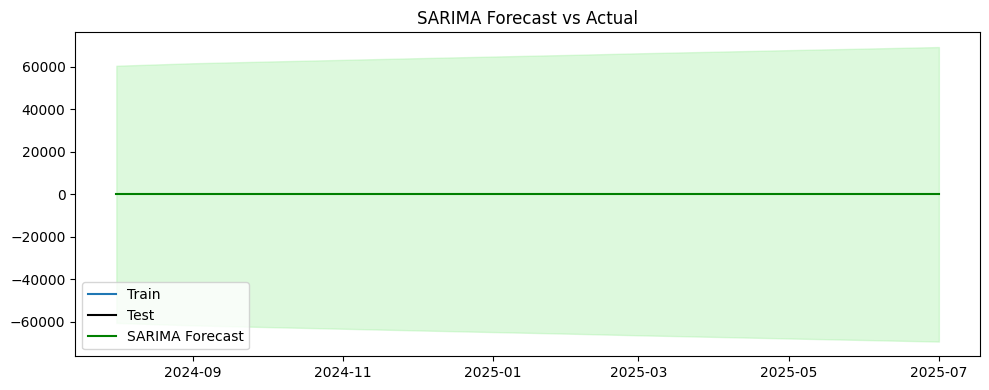


Exogenous variable (growth_rate) head:
            growth_rate
Date                   
2018-08-01          0.0
2018-09-01          0.0
2018-10-01          0.0
2018-11-01          0.0
2018-12-01          0.0

==== ARIMAX ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


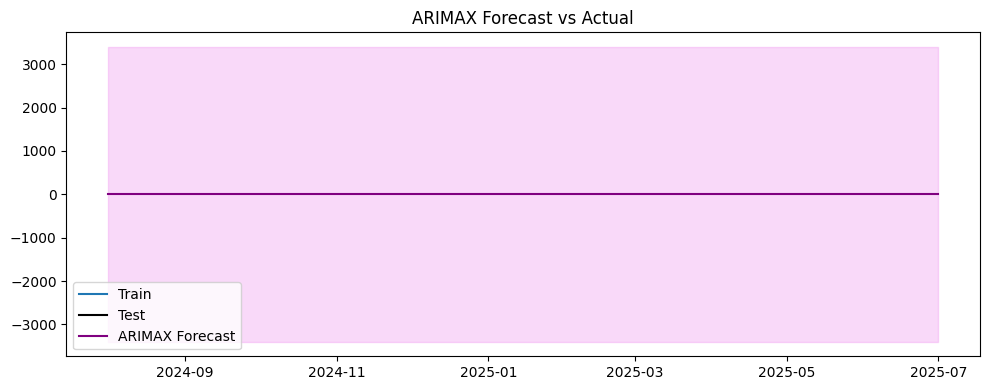


==== SARIMAX ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


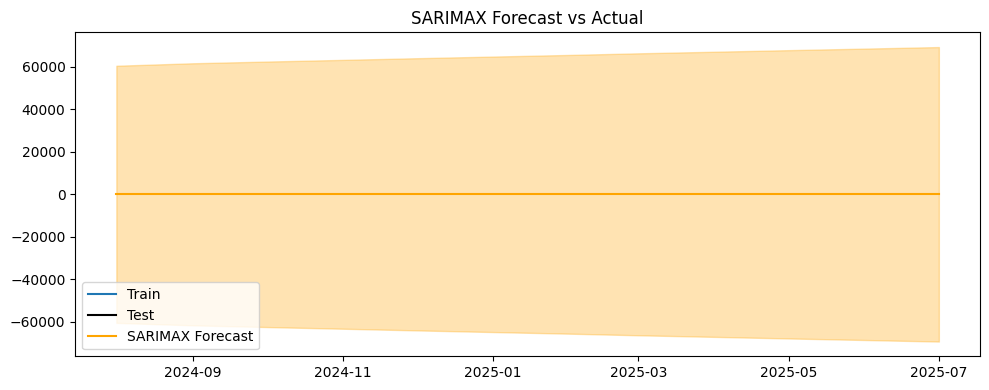


=== Model Comparison ===
     Model   AIC        BIC  RMSE  MAPE
0    ARIMA   6.0  12.702320   NaN   NaN
1   SARIMA  10.0  19.033312   NaN   NaN
2   ARIMAX   8.0  16.936426   NaN   NaN
3  SARIMAX  12.0  22.839975   NaN   NaN


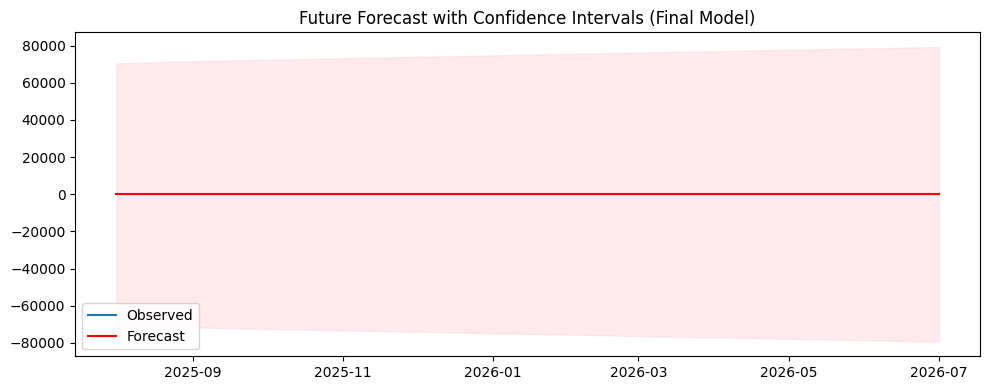


Future forecast values:
2025-08-01    0.0
2025-09-01    0.0
2025-10-01    0.0
2025-11-01    0.0
2025-12-01    0.0
2026-01-01    0.0
2026-02-01    0.0
2026-03-01    0.0
2026-04-01    0.0
2026-05-01    0.0
2026-06-01    0.0
2026-07-01    0.0
Freq: MS, Name: predicted_mean, dtype: float64


In [1]:

# TIME-SERIES FORECASTING: ARIMA / SARIMA / ARIMAX / SARIMAX

# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

#  LOAD & PREPROCESS DATA

file_path = "E:\Projects\data3_Cardiofocus_revenue.csv"
date_col   = "Date"       # column with dates
target_col = "Revenue"    # column with revenue/sales/target series

df = pd.read_csv(file_path)

# Convert date column to datetime and set as index
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col).set_index(date_col)

print("Initial data info:")
print(df.info())
print(df.head())

# Use only the target for time-series
ts = df[target_col].astype(float)

# Set frequency (assuming monthly; change 'MS' if needed)
ts = ts.asfreq('MS')

# Handle missing values
ts = ts.interpolate(method='linear')

print("\nTime series after setting freq & interpolation:")
print("Length:", len(ts), "| Non-missing:", ts.notna().sum())
print(ts.head())

#  OUTLIER DETECTION (simple IQR-based capping)

def cap_outliers(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

ts_clean = cap_outliers(ts)

# Plot original vs cleaned
plt.figure(figsize=(10, 4))
plt.plot(ts, label="Original")
plt.plot(ts_clean, label="Outlier-capped", linestyle="--")
plt.title("Original vs Cleaned Time Series")
plt.legend()
plt.tight_layout()
plt.show()

# Use cleaned series as final series
ts = ts_clean.copy()

#  STATIONARITY CHECK (SAFE ADF TEST) & TSA PLOTS

def adf_test(series, title=""):
    s = series.dropna()
    print(f"\nAugmented Dickey-Fuller Test: {title}")
    print("Length after dropna:", len(s))

    # If too few points, skip ADF
    if len(s) < 10:
        print("❗ Not enough data points for ADF test (need at least ~10). Skipping.")
        return

    try:
        result = adfuller(s, autolag="AIC")
    except ValueError as e:
        print("❗ ADF test error:", e)
        print("   (Series may be constant or invalid.)")
        return

    labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations"]
    for val, label in zip(result[:4], labels):
        print(f"{label}: {val}")
    for key, val in result[4].items():
        print(f"Critical Value ({key}): {val}")
    if result[1] <= 0.05:
        print("=> Series is likely STATIONARY (reject H0).")
    else:
        print("=> Series is likely NON-STATIONARY (fail to reject H0).")

# Plot series
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title("Target Time Series")
plt.xlabel("Time")
plt.ylabel(target_col)
plt.tight_layout()
plt.show()

# ADF test on original
adf_test(ts, title="Original Series")

# ACF & PACF for original (if enough points)
if ts.dropna().shape[0] > 10:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(ts.dropna(), ax=axes[0], lags=24)
    axes[0].set_title("ACF - Original Series")
    plot_pacf(ts.dropna(), ax=axes[1], lags=24, method="ywm")
    axes[1].set_title("PACF - Original Series")
    plt.tight_layout()
    plt.show()
else:
    print("❗ Not enough data for ACF/PACF of original series.")

#  DIFFERENCING TO ACHIEVE STATIONARITY (if needed)

ts_diff = ts.diff().dropna()

adf_test(ts_diff, title="1st Difference")

if ts_diff.shape[0] > 10:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(ts_diff, ax=axes[0], lags=24)
    axes[0].set_title("ACF - 1st Difference")
    plot_pacf(ts_diff, ax=axes[1], lags=24, method="ywm")
    axes[1].set_title("PACF - 1st Difference")
    plt.tight_layout()
    plt.show()
else:
    print("❗ Not enough data for ACF/PACF of differenced series.")

# Differencing order (set based on tests/plots)
d = 1

#  TRAIN-TEST SPLIT

test_size = 12  # last 12 periods as test

if len(ts) <= test_size:
    raise ValueError("Series too short for test_size=12. Reduce test_size or use more data.")

train_ts = ts.iloc[:-test_size]
test_ts  = ts.iloc[-test_size:]

print("\nTrain size:", train_ts.shape[0])
print("Test size :", test_ts.shape[0])

# HELPER FUNCTIONS: METRICS & RESIDUAL DIAGNOSTICS

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(true, pred, model_result, model_name="Model"):
    # Combine true and predicted values into one DataFrame
    df_eval = pd.concat([true, pred], axis=1)
    df_eval.columns = ["y_true", "y_pred"]

    before_len = len(df_eval)
    df_eval = df_eval.dropna()
    after_len = len(df_eval)

    # If all values are NaN, skip evaluation
    if after_len == 0:
        print(f"\n==== {model_name} ====")
        print("❗ No valid (non-NaN) true-pred pairs to evaluate.")
        return {
            "Model": model_name,
            "AIC": model_result.aic,
            "BIC": model_result.bic,
            "RMSE": np.nan,
            "MAPE": np.nan
        }

    print(f"\n[{model_name}] Using {after_len} valid points (dropped {before_len - after_len} NaNs).")

    y_true = df_eval["y_true"].values
    y_pred = df_eval["y_pred"].values

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mape(y_true, y_pred)

    print(f"\n==== {model_name} ====")
    print(f"AIC  : {model_result.aic:.2f}")
    print(f"BIC  : {model_result.bic:.2f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAPE : {mape_val:.3f}%")

    # Residual diagnostics
    residuals = model_result.resid
    print("\nResidual summary:")
    print(residuals.describe())

    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
    print("\nLjung-Box test (lag 10):")
    print(lb_test)

    # Residual plot
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title(f"Residuals - {model_name}")
    plt.tight_layout()
    plt.show()

    return {
        "Model": model_name,
        "AIC": model_result.aic,
        "BIC": model_result.bic,
        "RMSE": rmse,
        "MAPE": mape_val
    }

#  BASE MODELS: ARIMA & SARIMA

p, q = 1, 1        # example; tune using ACF/PACF
P, D, Q, m = 1, 1, 1, 12   # seasonal pattern (monthly, yearly seasonality)

metrics_list = []

# a. ARIMA (no seasonality, no exogenous)
arima_model = SARIMAX(train_ts,
                      order=(p, d, q),
                      seasonal_order=(0, 0, 0, 0),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
arima_result = arima_model.fit(disp=False)

arima_forecast = arima_result.get_forecast(steps=test_size)
arima_pred_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, arima_pred_mean, arima_result, "ARIMA")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, arima_pred_mean, label="ARIMA Forecast", color="red")
plt.fill_between(test_ts.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1],
                 color="pink", alpha=0.3)
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# b. SARIMA (seasonality, no exogenous)
sarima_model = SARIMAX(train_ts,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

sarima_forecast = sarima_result.get_forecast(steps=test_size)
sarima_pred_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, sarima_pred_mean, sarima_result, "SARIMA")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, sarima_pred_mean, label="SARIMA Forecast", color="green")
plt.fill_between(test_ts.index,
                 sarima_ci.iloc[:, 0],
                 sarima_ci.iloc[:, 1],
                 color="lightgreen", alpha=0.3)
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

#  CREATE GROWTH RATE (EXOGENOUS VARIABLE)

growth = ts.pct_change() * 100
growth = growth.replace([np.inf, -np.inf], np.nan).fillna(0)

exog = growth.to_frame(name="growth_rate")
exog_train = exog.iloc[:-test_size]
exog_test  = exog.iloc[-test_size:]

print("\nExogenous variable (growth_rate) head:")
print(exog.head())

#  ARIMAX & SARIMAX (WITH EXOGENOUS VARIABLES)

# a. ARIMAX (no seasonality, with exog)
arimax_model = SARIMAX(train_ts,
                       exog=exog_train,
                       order=(p, d, q),
                       seasonal_order=(0, 0, 0, 0),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

arimax_forecast = arimax_result.get_forecast(steps=test_size, exog=exog_test)
arimax_pred_mean = arimax_forecast.predicted_mean
arimax_ci = arimax_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, arimax_pred_mean, arimax_result, "ARIMAX")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, arimax_pred_mean, label="ARIMAX Forecast", color="purple")
plt.fill_between(test_ts.index,
                 arimax_ci.iloc[:, 0],
                 arimax_ci.iloc[:, 1],
                 color="violet", alpha=0.3)
plt.title("ARIMAX Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# b. SARIMAX (seasonality + exog)
sarimax_model = SARIMAX(train_ts,
                        exog=exog_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)

sarimax_forecast = sarimax_result.get_forecast(steps=test_size, exog=exog_test)
sarimax_pred_mean = sarimax_forecast.predicted_mean
sarimax_ci = sarimax_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, sarimax_pred_mean, sarimax_result, "SARIMAX")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, sarimax_pred_mean, label="SARIMAX Forecast", color="orange")
plt.fill_between(test_ts.index,
                 sarimax_ci.iloc[:, 0],
                 sarimax_ci.iloc[:, 1],
                 color="orange", alpha=0.3)
plt.title("SARIMAX Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

#  MODEL COMPARISON TABLE

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.sort_values(by="RMSE")
print("\n=== Model Comparison ===")
print(metrics_df)

#  FINAL MODEL & FUTURE FORECASTS WITH CONFIDENCE INTERVALS

final_exog = exog  # full exog for entire series

final_sarimax = SARIMAX(ts,
                        exog=final_exog,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

n_forecast = 12  # forecast 12 future periods

future_index = pd.date_range(start=ts.index[-1] + ts.index.freq,
                             periods=n_forecast,
                             freq=ts.index.freq)

future_growth = pd.Series(
    exog["growth_rate"].tail(12).mean(),
    index=future_index,
    name="growth_rate"
)
future_exog = future_growth.to_frame()

final_forecast = final_sarimax.get_forecast(steps=n_forecast, exog=future_exog)
final_pred_mean = final_forecast.predicted_mean
final_ci = final_forecast.conf_int()

plt.figure(figsize=(10, 4))
plt.plot(ts.index, ts, label="Observed")
plt.plot(final_pred_mean.index, final_pred_mean, label="Forecast", color="red")
plt.fill_between(final_pred_mean.index,
                 final_ci.iloc[:, 0],
                 final_ci.iloc[:, 1],
                 color="pink", alpha=0.3)
plt.title("Future Forecast with Confidence Intervals (Final Model)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nFuture forecast values:")
print(final_pred_mean)